<a href="https://colab.research.google.com/github/Ritikaverma2021/Distracted_Driver/blob/main/MobileNet_No_Extra_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

from keras import backend as K
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import imagenet_utils
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from IPython.display import Image

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model
from tensorflow.keras import optimizers

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
!nvidia-smi

Sat Oct  1 02:00:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
driver_details = pd.read_csv('/content/drive/MyDrive/mini_data_set/Copy of driver_imgs_list (1).csv',na_values='na')
print(driver_details.head(5))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [ ]:
# getting all the images
train_image = []
image_label = []


for i in range(10):
    print('folder C',i)
    imgs = os.listdir("/content/drive/MyDrive/mini_data_set/Train/C"+str(i))
    for j in range(len(imgs)):
        img_name = "/content/drive/MyDrive/mini_data_set/Train/C"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)

folder C 0
folder C 1
folder C 2
folder C 3
folder C 4
folder C 5
folder C 6
folder C 7
folder C 8
folder C 9


In [ ]:
# Randomly shuffling the images

import random
random.shuffle(train_image)

In [ ]:
# getting list of driver names

D = []
for features,labels,drivers in train_image:
    D.append(drivers)

## Deduplicating drivers

deduped = []

for i in D:
    if i not in deduped:
        deduped.append(i)
    

## selecting random drivers for the validation set
driv_selected = []
import random
driv_nums = random.sample(range(len(deduped)), 4)
for i in driv_nums:
    driv_selected.append(deduped[i])
driv_selected 

['p035', 'p064', 'p047', 'p041']

In [ ]:
# training and splitting the training and testing data

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []
true_test=[]

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
        true_test.append(labels)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

4320 680
4320 680


In [ ]:
# Converting images to nparray. Encoding the Y.

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print(X_train.shape)
print(y_train.shape)

(4320, 224, 224, 3)
(4320, 10)


In [ ]:
# The MobileNet model

model_mobilenet = MobileNet(weights='imagenet', include_top= False)
model_mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                         

In [ ]:
x = model_mobilenet.output
x = GlobalAveragePooling2D()(x)

prediction = Dense(10, activation='softmax')(x)
model = Model(model_mobilenet.input, prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                      

In [ ]:
sgd = optimizers.SGD(lr=0.0005)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('mobilenet_sgd_nolayers.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
mobilenet_model = model.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 10, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/10
68/67 [==============================] - ETA: 0s - loss: 2.6290 - accuracy: 0.0914
Epoch 1: val_loss improved from inf to 2.74040, saving model to mobilenet_sgd_nolayers.hdf5
67/67 [==============================] - 68s 781ms/step - loss: 2.6290 - accuracy: 0.0914 - val_loss: 2.7404 - val_accuracy: 0.1294
Epoch 2/10
68/67 [==============================] - ETA: 0s - loss: 2.5359 - accuracy: 0.1069
Epoch 2: val_loss improved from 2.74040 to 2.48884, saving model to mobilenet_sgd_nolayers.hdf5
67/67 [==============================] - 51s 754ms/step - loss: 2.5359 - accuracy: 0.1069 - val_loss: 2.4888 - val_accuracy: 0.1691
Epoch 3/10
68/67 [==============================] - ETA: 0s - loss: 2.4737 - accuracy: 0.1187
Epoch 3: val_loss improved from 2.48884 to 2.38524, saving model to mobilenet_sgd_nolayers.hdf5
67/67 [==============================] - 52s 771ms/step - loss: 2.4737 - accuracy: 0.1187 - val_loss: 2.3852 - val_accuracy: 0.1647
Epoch 4/10
68/67 [====================

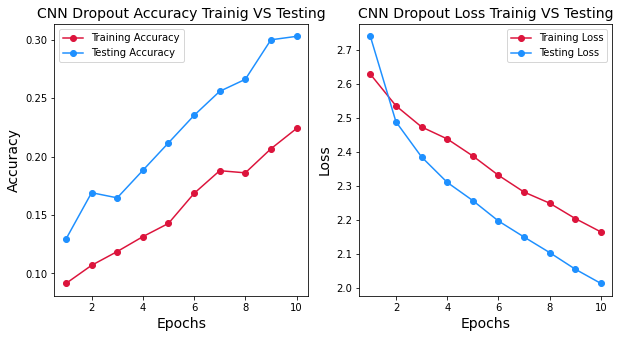

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(model.history.history['accuracy']) + 1), model.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(model.history.history['val_accuracy']) + 1), model.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')


axes[1].plot(range(1, len(model.history.history['loss']) + 1), model.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(model.history.history['val_loss']) + 1), model.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

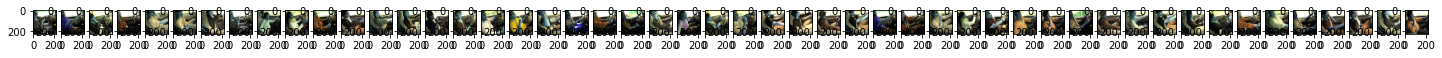

In [ ]:
# Labels is the image array
test_images =[]
i=0
fig,ax =plt.subplots(1,50, figsize=(25,25))

files = os.listdir('/content/drive/MyDrive/mini_data_set/Test')
nums = np.random.randint(low=1, high =len(files), size =50)
for i in range(50):
  #print('Image Number : ', i)
  img = cv2.imread('/content/drive/MyDrive/mini_data_set/Test/'+ files[nums[i]])
  img = img [50:, 120:-50]
  img = cv2.resize(img,(224,224))
  test_images.append(img)
  ax[i].imshow(img, cmap='gray')
  plt.show

In [ ]:
test = []

for img in test_images:
    test.append(img)
    
model.load_weights('mobilenet_sgd_nolayers.hdf5')


test = np.array(test).reshape(-1,224,224,3)
prediction = model.predict(test)

In [ ]:
prediction[7]

array([0.04081579, 0.22728199, 0.16975424, 0.08909567, 0.1119149 ,
       0.0129143 , 0.11818946, 0.06259102, 0.09090702, 0.07653562],
      dtype=float32)

In [ ]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

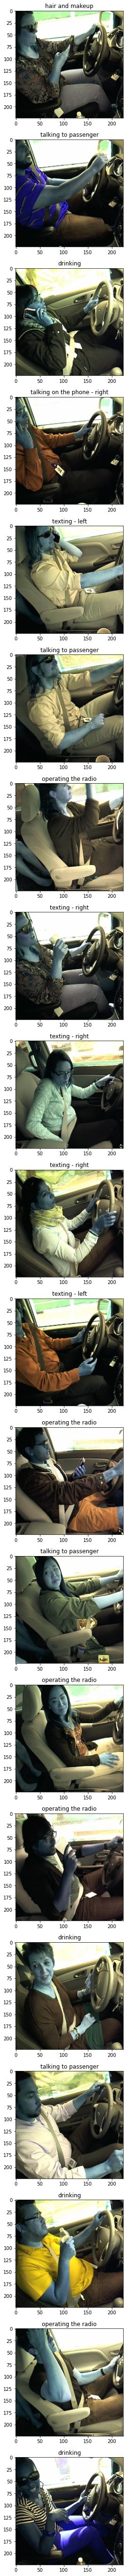

In [ ]:
# labels is the image array
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))

for i in range(20):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show

In [ ]:
model8_prediction = []
model8_pred_class = []

model8_prediction = model_mobilenet.predict(X_test)
print('Images Predicted until now:',len(model8_prediction))


for i in range(len(model8_prediction)):
    model8_pred_class.append(np.where(model8_prediction[i] == np.amax(model8_prediction[i]))[0][0])

    
print('The accuracy of this model over validation set is:',accuracy_score(true_test,model8_pred_class))
confusion_matrix(true_test,model8_pred_class)

Images Predicted until now: 680
The accuracy of this model over validation set is: 0.11470588235294117


array([[78,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [71,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [62,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [60,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [64,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [66,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [59,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [87,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [74,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [59,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
#from sklearn.metrics import log_loss

#lgloss = log_loss(y_test, model8_prediction, eps=1e-15, normalize=True, sample_weight=None, labels=None)

#print('The log loss from this model is:',round(lgloss,2))